In [76]:
!pip install category-encoders

In [154]:
import pandas as pd
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce


np.random.seed(7)

In [155]:
df_main = pd.read_csv("/content/historical_data.csv")
print(df_main.info())
df_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [156]:
df_main.created_at = pd.to_datetime(df_main.created_at)
df_main.actual_delivery_time = pd.to_datetime(df_main.actual_delivery_time)

In [157]:
ColumnNames = {
    'market_id':'city',
    'created_at':'start',
    'actual_delivery_time':'eta',
    'store_id':'store',
    'store_primary_category':'cusine',
    'order_protocol':'protocol',
    'total_items':'items',
    'subtotal': 'value',
    'num_distinct_items':'unique_items',
    'min_item_price':'min_value',
    'max_item_price':'max_value',
    'total_onshift_dashers':'available_dashers',
    'total_busy_dashers':'total_dashers',
    'total_outstanding_orders':'orders',
    'estimated_order_place_duration':'pred_eot',
    'estimated_store_to_consumer_driving_duration': 'pred_eta'
}
df_main.rename(columns=ColumnNames,inplace=True)
df_main.head()

,city,start,eta,store,cusine,protocol,items,value,unique_items,min_value,max_value,available_dashers,total_dashers,orders,pred_eot,pred_eta
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [158]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   city               196441 non-null  float64       
 1   start              197428 non-null  datetime64[ns]
 2   eta                197421 non-null  datetime64[ns]
 3   store              197428 non-null  int64         
 4   cusine             192668 non-null  object        
 5   protocol           196433 non-null  float64       
 6   items              197428 non-null  int64         
 7   value              197428 non-null  int64         
 8   unique_items       197428 non-null  int64         
 9   min_value          197428 non-null  int64         
 10  max_value          197428 non-null  int64         
 11  available_dashers  181166 non-null  float64       
 12  total_dashers      181166 non-null  float64       
 13  orders             181166 non-null  float64 

In [159]:
#Make date time as data useful data
df_main['eta_sec'] = (df_main['eta']-df_main['start']).dt.total_seconds()
df_main['pred_total_est'] = df_main['pred_eot'] + df_main['pred_eta']
df_main['start_hour'] = df_main['start'].dt.hour
df_main['start_week_day'] = df_main['start'].dt.dayofweek
df_main.drop(['start', 'eta'], axis=1, inplace=True)
df_main.head()

,city,store,cusine,protocol,items,value,unique_items,min_value,max_value,available_dashers,total_dashers,orders,pred_eot,pred_eta,eta_sec,pred_total_est,start_hour,start_week_day
0,1.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,22,4
1,2.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,21,1
2,3.0,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,20,3
3,3.0,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,21,1
4,3.0,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,2,6


In [160]:
df_main['dashers_ratio'] = df_main['available_dashers']/df_main['total_dashers']
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   city               196441 non-null  float64
 1   store              197428 non-null  int64  
 2   cusine             192668 non-null  object 
 3   protocol           196433 non-null  float64
 4   items              197428 non-null  int64  
 5   value              197428 non-null  int64  
 6   unique_items       197428 non-null  int64  
 7   min_value          197428 non-null  int64  
 8   max_value          197428 non-null  int64  
 9   available_dashers  181166 non-null  float64
 10  total_dashers      181166 non-null  float64
 11  orders             181166 non-null  float64
 12  pred_eot           197428 non-null  int64  
 13  pred_eta           196902 non-null  float64
 14  eta_sec            197421 non-null  float64
 15  pred_total_est     196902 non-null  float64
 16  st

In [161]:
df_main.dashers_ratio.describe() #we have inf in this because of the division

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,dashers_ratio
count,1.775900e+05
mean,NaN
std,NaN
min,-inf
25%,1.000000e+00
50%,1.039216e+00
75%,1.209302e+00
max,inf


In [162]:
print(df_main[df_main["dashers_ratio"] == np.inf].dashers_ratio.count())
print(df_main[df_main["dashers_ratio"] == -np.inf].dashers_ratio.count())
print(df_main.shape)
df_main.replace([np.inf, -np.inf], np.nan, inplace=True)
df_main.isnull().sum()

594
1
(197428, 19)


,0
city,987
store,0
cusine,4760
protocol,995
items,0
value,0
unique_items,0
min_value,0
max_value,0
available_dashers,16262


In [163]:
print('store', df_main['store'].nunique())
print('cusine', df_main['cusine'].nunique())
print('protocol', df_main['protocol'].nunique())
print('city', df_main['city'].nunique())
print('city', df_main['city'].unique())
print('protocol', df_main['protocol'].unique())

store 6743
cusine 74
protocol 7
city 6
city [ 1.  2.  3.  4. nan  5.  6.]
protocol [ 1.  2.  3.  4. nan  5.  6.  7.]


fill na values for cusine from store by taking the most frequent cusine out of a store

In [164]:
store_unique = df_main["store"].unique().tolist()
store_cusine = {store: df_main[df_main.store == store].cusine.mode() for store in store_unique}
def fill(store):
    fill_cusine = store_cusine.get(store, None)
    if fill_cusine is None or fill_cusine.empty:
        return np.nan
    return fill_cusine.values[0]

df_main["fill_cusine"] = df_main.store.apply(fill)
df_main.head()

,city,store,cusine,protocol,items,value,unique_items,min_value,max_value,available_dashers,total_dashers,orders,pred_eot,pred_eta,eta_sec,pred_total_est,start_hour,start_week_day,dashers_ratio,fill_cusine
0,1.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,22,4,2.357143,american
1,2.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,21,1,0.500000,indian
2,3.0,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,20,3,NaN,indian
3,3.0,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,21,1,1.000000,indian
4,3.0,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,2,6,1.000000,indian


In [165]:
df_encoded = pd.get_dummies(df_main, columns=['city', 'protocol', 'fill_cusine'],
                            prefix={'city': 'city', 'protocol': 'proto', 'fill_cusine':'cus'})
df_encoded.head()

,store,cusine,items,value,unique_items,min_value,max_value,available_dashers,total_dashers,orders,...,cus_southern,cus_spanish,cus_steak,cus_sushi,cus_tapas,cus_thai,cus_turkish,cus_vegan,cus_vegetarian,cus_vietnamese
0,1845,american,4,3441,4,557,1239,33.0,14.0,21.0,...,False,False,False,False,False,False,False,False,False,False
1,5477,mexican,1,1900,1,1400,1400,1.0,2.0,2.0,...,False,False,False,False,False,False,False,False,False,False
2,5477,NaN,1,1900,1,1900,1900,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,5477,NaN,6,6900,5,600,1800,1.0,1.0,2.0,...,False,False,False,False,False,False,False,False,False,False
4,5477,NaN,3,3900,3,1100,1600,6.0,6.0,9.0,...,False,False,False,False,False,False,False,False,False,False


In [166]:
df_encoded = df_encoded.drop(columns = ['store', 'cusine'])
df_encoded.head()

,items,value,unique_items,min_value,max_value,available_dashers,total_dashers,orders,pred_eot,pred_eta,...,cus_southern,cus_spanish,cus_steak,cus_sushi,cus_tapas,cus_thai,cus_turkish,cus_vegan,cus_vegetarian,cus_vietnamese
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,...,False,False,False,False,False,False,False,False,False,False
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,...,False,False,False,False,False,False,False,False,False,False
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,...,False,False,False,False,False,False,False,False,False,False
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,...,False,False,False,False,False,False,False,False,False,False
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,...,False,False,False,False,False,False,False,False,False,False


In [167]:
df_encoded = df_encoded.astype("float32")
df_encoded.head()

,items,value,unique_items,min_value,max_value,available_dashers,total_dashers,orders,pred_eot,pred_eta,...,cus_southern,cus_spanish,cus_steak,cus_sushi,cus_tapas,cus_thai,cus_turkish,cus_vegan,cus_vegetarian,cus_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
df_encoded.describe()

,items,value,unique_items,min_value,max_value,available_dashers,total_dashers,orders,pred_eot,pred_eta,...,cus_southern,cus_spanish,cus_steak,cus_sushi,cus_tapas,cus_thai,cus_turkish,cus_vegan,cus_vegetarian,cus_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.665833,1822.968994,1.629398,522.068542,558.358337,34.524193,32.146065,52.657368,90.211159,219.350143,...,0.028535,0.013687,0.073625,0.105705,0.027175,0.189502,0.034246,0.037816,0.064904,0.173167
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [170]:
print(df_encoded.shape)
df_floats_encoded = df_encoded.dropna()
df_floats_encoded.shape

(197428, 102)


(176518, 102)

In [171]:
df_floats_encoded.isna().sum().sum()

np.int64(0)

We got a clean data out of this. But we still have redundant features present in the data which has to be cleared

<Axes: >

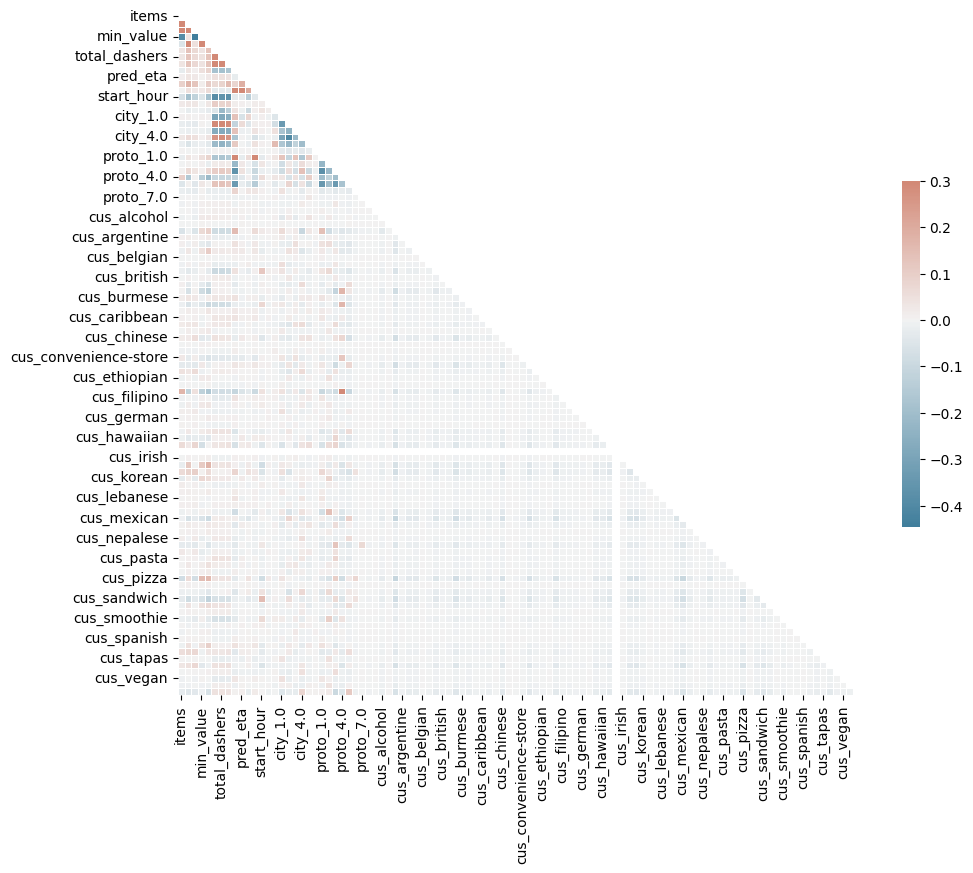

In [177]:
corr = df_floats_encoded.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [184]:
zero_std_cols = df_floats_encoded.std(numeric_only=True)
zero_std_cols = zero_std_cols[zero_std_cols == 0].index.tolist()

print("Columns with std = 0:", zero_std_cols)

Columns with std = 0: ['cus_indonesian']


In [185]:
df_floats_encoded['cus_indonesian'].describe()

,cus_indonesian
count,176518.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [183]:
def get_pairs(df):
    pairs = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs.add((cols[i], cols[j]))
    return pairs

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print(get_top_abs_correlations(df_floats_encoded, 25))

Top Absolute Correlations
available_dashers  total_dashers     0.941439
                   orders            0.934380
total_dashers      orders            0.931039
pred_eta           pred_total_est    0.923202
pred_eot           proto_1.0         0.897663
items              unique_items      0.757998
value              unique_items      0.683173
items              value             0.557235
min_value          max_value         0.540894
value              max_value         0.507616
proto_4.0          cus_fast          0.490664
unique_items       min_value         0.446830
city_2.0           city_4.0          0.403961
items              min_value         0.389263
available_dashers  start_hour        0.382724
proto_1.0          proto_3.0         0.373319
orders             start_hour        0.368387
pred_eot           proto_3.0         0.363940
                   pred_total_est    0.363274
total_dashers      start_hour        0.357211
proto_1.0          proto_5.0         0.342135
city_1.0

In [186]:
# drop std == 0 and also very dense correlated ones
df_floats_encoded = df_floats_encoded.drop(columns=["cus_indonesian", "total_dashers", "available_dashers", "pred_total_est"])
df_floats_encoded.head()

,items,value,unique_items,min_value,max_value,orders,pred_eot,pred_eta,eta_sec,start_hour,...,cus_southern,cus_spanish,cus_steak,cus_sushi,cus_tapas,cus_thai,cus_turkish,cus_vegan,cus_vegetarian,cus_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,5000.0,3.0,1500.0,1900.0,2.0,446.0,338.0,2300.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
print(get_top_abs_correlations(df_floats_encoded, 25))

pred_eot      proto_1.0       0.897663
items         unique_items    0.757998
value         unique_items    0.683173
items         value           0.557235
min_value     max_value       0.540894
value         max_value       0.507616
proto_4.0     cus_fast        0.490664
unique_items  min_value       0.446830
city_2.0      city_4.0        0.403961
items         min_value       0.389263
proto_1.0     proto_3.0       0.373319
orders        start_hour      0.368387
pred_eot      proto_3.0       0.363940
proto_1.0     proto_5.0       0.342135
city_1.0      city_2.0        0.334886
proto_3.0     proto_5.0       0.333344
pred_eot      proto_5.0       0.333076
city_1.0      city_4.0        0.302361
orders        city_2.0        0.287953
              city_4.0        0.263840
              city_3.0        0.261088
              city_1.0        0.258924
city_2.0      city_3.0        0.239711
proto_1.0     proto_2.0       0.226657
city_2.0      city_5.0        0.223813
dtype: float64


In [195]:
df_floats_encoded_no_city_no_protocol = df_floats_encoded.drop(columns=['city_1.0', 'city_2.0', 'city_3.0', 'city_4.0', 'city_5.0', 'city_6.0',
                                                                        'proto_1.0', 'proto_2.0', 'proto_3.0', 'proto_4.0', 'proto_5.0', 'proto_6.0', 'proto_7.0'])

In [196]:
print(get_top_abs_correlations(df_floats_encoded_no_city_no_protocol, 25))

items         unique_items     0.757998
value         unique_items     0.683173
items         value            0.557235
min_value     max_value        0.540894
value         max_value        0.507616
unique_items  min_value        0.446830
items         min_value        0.389263
orders        start_hour       0.368387
value         start_hour       0.189415
max_value     start_hour       0.188511
pred_eta      eta_sec          0.188302
value         eta_sec          0.172042
items         cus_fast         0.171026
orders        pred_eot         0.169783
max_value     cus_italian      0.169762
              cus_fast         0.165667
              cus_pizza        0.157498
orders        eta_sec          0.156991
start_hour    cus_sandwich     0.152615
pred_eot      cus_american     0.149715
min_value     cus_pizza        0.149670
orders        dashers_ratio    0.138098
eta_sec       start_hour       0.137094
value         orders           0.130044
max_value     orders           0.128257


since, we still have high correlation for cols like unique_items, value ..

In [198]:
df_floats_encoded_no_city_no_protocol["unique_percent"] = df_floats_encoded_no_city_no_protocol["unique_items"] / df_floats_encoded_no_city_no_protocol["items"]
df_floats_encoded_no_city_no_protocol["avg_value"] = df_floats_encoded_no_city_no_protocol["value"] / df_floats_encoded_no_city_no_protocol["items"]
df_new_encoded = df_floats_encoded_no_city_no_protocol.drop(columns=["unique_items", "value"])
print(get_top_abs_correlations(df_new_encoded, 25))

min_value       avg_value         0.860482
max_value       avg_value         0.770144
min_value       max_value         0.540894
items           unique_percent    0.445541
                min_value         0.389263
orders          start_hour        0.368387
items           avg_value         0.310779
unique_percent  avg_value         0.226643
cus_pizza       avg_value         0.225602
max_value       start_hour        0.188511
pred_eta        eta_sec           0.188302
max_value       unique_percent    0.177976
cus_fast        avg_value         0.175533
min_value       unique_percent    0.173455
items           cus_fast          0.171026
orders          pred_eot          0.169783
max_value       cus_italian       0.169762
                cus_fast          0.165667
cus_italian     avg_value         0.158248
max_value       cus_pizza         0.157498
orders          eta_sec           0.156991
cus_fast        unique_percent    0.153279
start_hour      cus_sandwich      0.152615
pred_eot   

In [199]:
df_new_encoded["value_range"] = df_new_encoded["max_value"] - df_new_encoded["min_value"]
df_new_encode = df_new_encoded.drop(columns=["max_value", "min_value"])
print(get_top_abs_correlations(df_new_encode, 20))

items           unique_percent    0.445541
orders          start_hour        0.368387
items           value_range       0.333249
                avg_value         0.310779
unique_percent  avg_value         0.226643
cus_pizza       avg_value         0.225602
pred_eta        eta_sec           0.188302
cus_fast        avg_value         0.175533
items           cus_fast          0.171026
orders          pred_eot          0.169783
cus_italian     avg_value         0.158248
orders          eta_sec           0.156991
cus_fast        unique_percent    0.153279
start_hour      value_range       0.153127
                cus_sandwich      0.152615
pred_eot        cus_american      0.149715
orders          dashers_ratio     0.138098
eta_sec         start_hour        0.137094
start_hour      avg_value         0.121798
                cus_breakfast     0.119308
dtype: float64


In [200]:
df_new_encode.shape

(176518, 84)

After removing the cols with std = 0 and high correlations, we check multi-colinearity

In [203]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif_score(features): # < 20
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df_new_encode[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [205]:
features = df_new_encode.drop(columns=["eta_sec"]).columns.to_list()
vif_data = get_vif_score(features)
vif_data

,feature,VIF
0,cus_alcohol-plus-food,1.000373
1,cus_chocolate,1.000540
2,cus_belgian,1.000863
3,cus_russian,1.003363
4,cus_african,1.004099
...,...,...
78,pred_eta,7.215945
79,dashers_ratio,7.431139
80,cus_american,7.450878
81,pred_eot,13.603008


except for unique_percent, everything is good

In [210]:
feature_selection = vif_data['feature'].values.tolist()
feature_selection.pop(-1)
feature_selection

['cus_alcohol-plus-food',
 'cus_chocolate',
 'cus_belgian',
 'cus_russian',
 'cus_african',
 'cus_gluten-free',
 'cus_european',
 'cus_spanish',
 'cus_comfort-food',
 'cus_cheese',
 'cus_moroccan',
 'cus_singaporean',
 'cus_southern',
 'cus_kosher',
 'cus_irish',
 'cus_argentine',
 'cus_soup',
 'cus_german',
 'cus_afghan',
 'cus_malaysian',
 'cus_tapas',
 'cus_ethiopian',
 'cus_pakistani',
 'cus_british',
 'cus_lebanese',
 'cus_gastropub',
 'cus_turkish',
 'cus_convenience-store',
 'cus_peruvian',
 'cus_vegan',
 'cus_brazilian',
 'cus_caribbean',
 'cus_nepalese',
 'cus_filipino',
 'cus_bubble-tea',
 'cus_cajun',
 'cus_latin-american',
 'cus_french',
 'cus_persian',
 'cus_pasta',
 'cus_burmese',
 'cus_vegetarian',
 'cus_dim-sum',
 'cus_steak',
 'cus_smoothie',
 'cus_middle-eastern',
 'cus_hawaiian',
 'cus_catering',
 'cus_korean',
 'cus_alcohol',
 'cus_cafe',
 'cus_sushi',
 'cus_asian',
 'cus_seafood',
 'cus_barbecue',
 'cus_greek',
 'cus_salad',
 'cus_other',
 'value_range',
 'start_ho

In [211]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df_new_encoded[feature_selection]
y = df_new_encoded["eta_sec"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

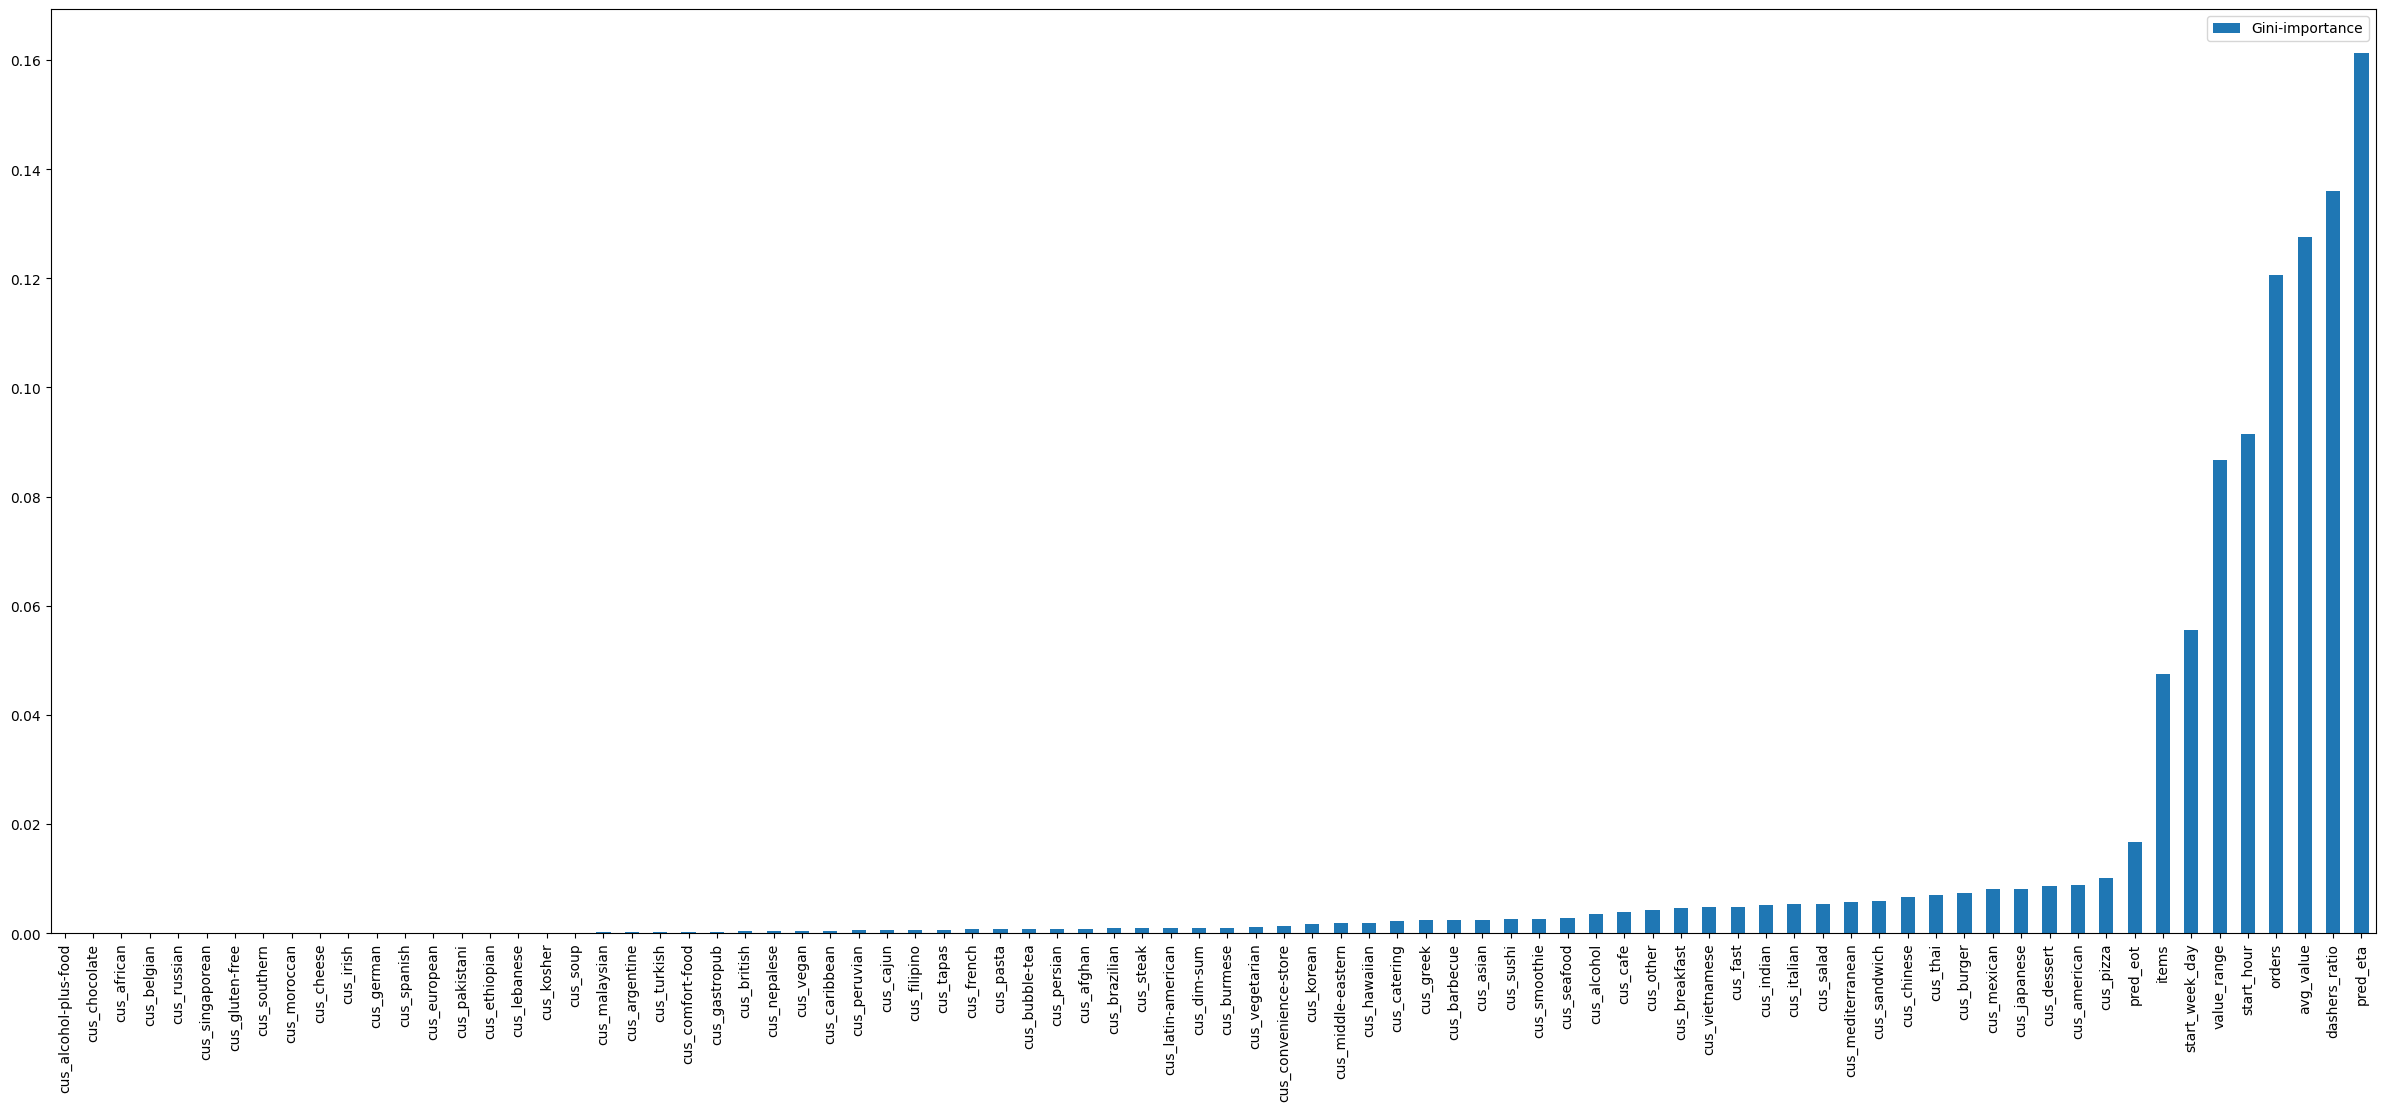

In [212]:
forest = RandomForestRegressor(random_state=7)
forest.fit(X_train, y_train)
feats = {}
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(30,12))
plt.show()

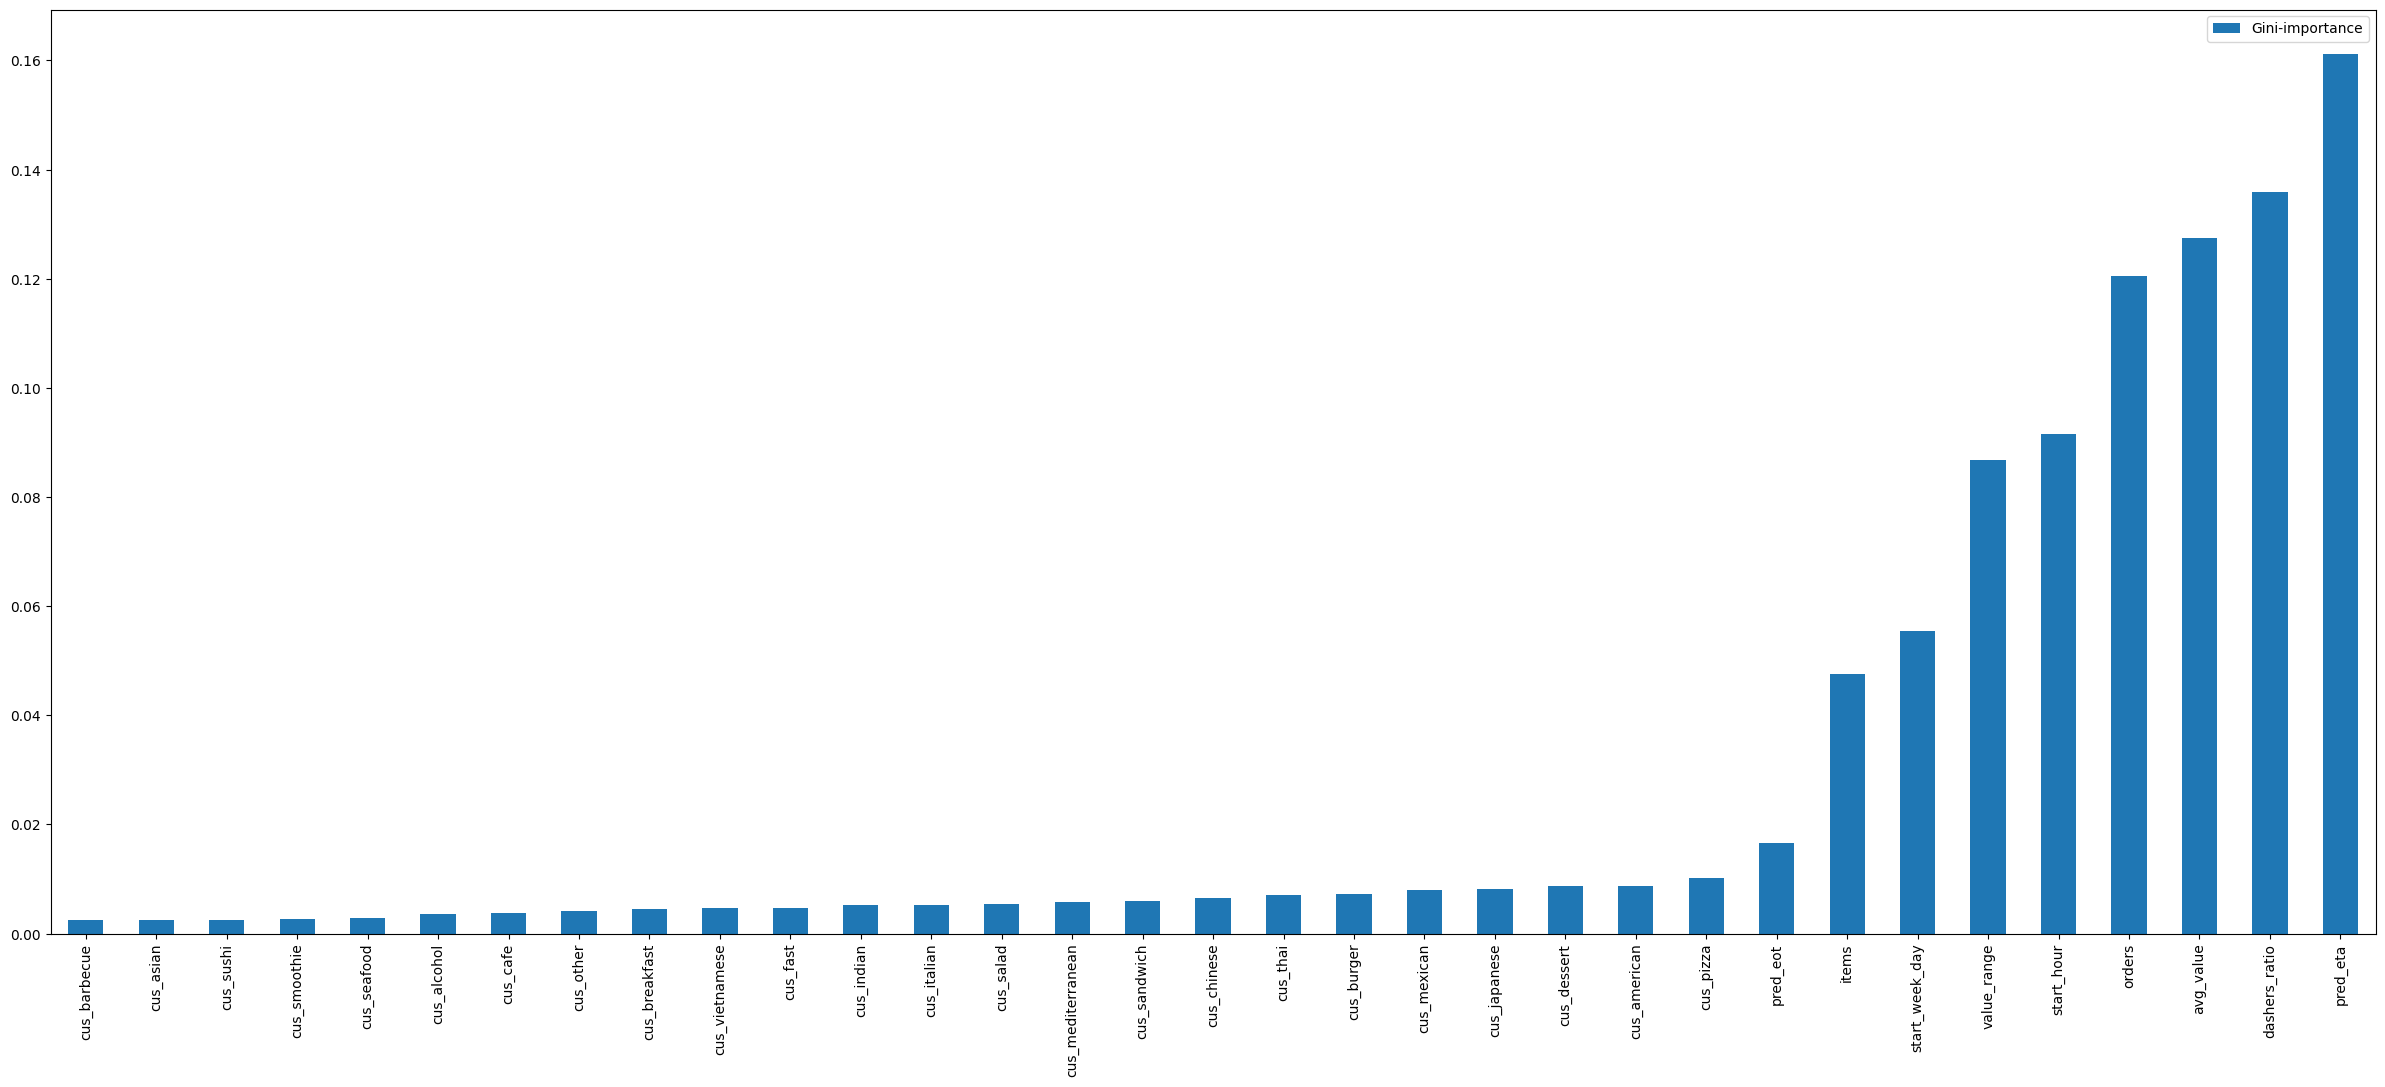

In [215]:
importances.sort_values(by='Gini-importance')[-33:].plot(kind='bar', rot=90, figsize=(30,12))
plt.show()

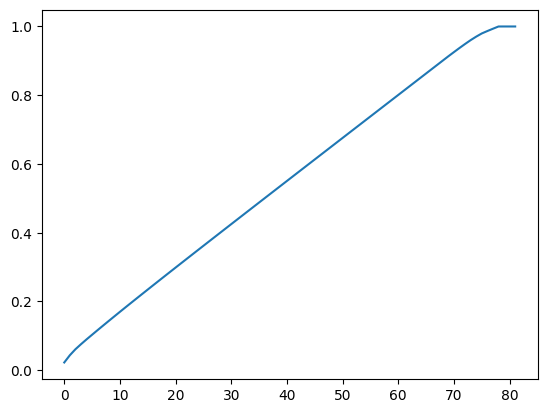

In [216]:
# apply PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)


X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

80% variance explained by 60 features.. not uch difference.. so no need to use this for now

In [228]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

def scale(scaler, X, y):
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))

    return X_scaled, y_scaled, X_scaler, y_scaler


def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    rmse_error = np.sqrt(mean_squared_error(y_test, y_predict[:,0]))
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)
    return rmse_error, y_predict

def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    model.fit(X_train,y_train)
    y_predict=model.predict(X_train)
    train_error = np.sqrt(mean_squared_error(y_train, y_predict))
    y_predict=model.predict(X_test)
    test_error = np.sqrt(mean_squared_error(y_test, y_predict))
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model
    return trained_model, y_predict, train_error, test_error

In [229]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}


regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}

feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_32": importances.sort_values(by='Gini-importance')[-33:].index.tolist(),
    "selected_features_22": importances.sort_values(by='Gini-importance')[-22:].index.tolist(),
    "selected_features_11": importances.sort_values(by='Gini-importance')[-11:].index.tolist(),
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

In [231]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            if scaler_name == "NotScale":
                X = df_new_encoded[feature_set]
                y = df_new_encoded["eta_sec"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)

            else:

                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are full dataset

Error = 2192.5805572429945 in Ridge
Error = 2195.741452119967 in DecisionTree
Error = 2247.07071092804 in RandomForest
Error = 2278.110510927861 in XGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.246512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 72
[LightGBM] [Info] Start training from score 0.000157


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Error = 2220.063699499477 in LGBM
Error = 2235.1893655795698 in MLP
-----scaled with MinMax scaler-------- included columns are full dataset

Error = 2189.7487298774718 in Ridge
Error = 2195.7414528229683 in DecisionTree
Error = 2234.1448619474586 in RandomForest
Error = 2277.1960829054665 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1493
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 72
[LightGBM] [Info] Start training from score 0.008289


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Error = 2223.0845308815274 in LGBM
Error = 2308.2429464854863 in MLP
-----scaled with NotScale-------- included columns are full dataset



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.45031e-11): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Train error = 1377.9032531349942 in Ridge
Test error = 1082.2049828937215 in Ridge
Train error = 1362.1257985681054 in DecisionTree
Test error = 1066.7976605830238 in DecisionTree
Train error = 541.676836268548 in RandomForest
Test error = 1051.2113095724649 in RandomForest
Train error = 940.9734653538324 in XGBoost
Test error = 1123.1382372620033 in XGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 72
[LightGBM] [Info] Start training from score 2856.197842
Train error = 1184.9777252572712 in LGBM
Test error = 1021.3384027011065 in LGBM


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1368.7567351432467 in MLP
Test error = 1066.1335516716467 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_32

Error = 1083.1619800380736 in Ridge
Error = 1066.6291771791346 in DecisionTree
Error = 1034.1681632251473 in RandomForest
Error = 1083.2543560955571 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1446
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 33
[LightGBM] [Info] Start training from score 0.000157


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Error = 1023.8187587084884 in LGBM
Error = 1050.598936321563 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_32

Error = 1080.691734492311 in Ridge
Error = 1066.629177124102 in DecisionTree
Error = 1044.8452169814302 in RandomForest
Error = 1057.2786411348714 in XGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 33
[LightGBM] [Info] Start training from score 0.008289


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Error = 1024.4907360043924 in LGBM
Error = 1201.7063389197879 in MLP
-----scaled with NotScale-------- included columns are selected_features_32

Train error = 1378.9442519550962 in Ridge
Test error = 1083.1622108437869 in Ridge


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.00718e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Train error = 1362.2266501486874 in DecisionTree
Test error = 1066.629177043492 in DecisionTree
Train error = 549.5096289725153 in RandomForest
Test error = 1042.2788975930548 in RandomForest
Train error = 927.3258933621987 in XGBoost
Test error = 1083.2543560955571 in XGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 33
[LightGBM] [Info] Start training from score 2856.197842
Train error = 1185.7477017026238 in LGBM
Test error = 1025.3298381788939 in LGBM
Train error = 1369.9978558377381 in MLP
Test error = 1068.244646604887 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_22

Error = 1084.4574104131523 in Ridge
Error = 1066.6291771791346 in DecisionTree
Error = 1031.8129175704657 in RandomForest
Error = 107

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Error = 1022.6256821342348 in LGBM
Error = 1045.623199340948 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_22

Error = 1081.9722732122113 in Ridge
Error = 1066.629177124102 in DecisionTree
Error = 1034.0987511995068 in RandomForest
Error = 1071.1985693605084 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1393
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 22
[LightGBM] [Info] Start training from score 0.008289


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Error = 1024.41944131818 in LGBM
Error = 1212.0550214408586 in MLP
-----scaled with NotScale-------- included columns are selected_features_22

Train error = 1379.7786054291464 in Ridge
Test error = 1084.4575833106614 in Ridge


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.81242e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Train error = 1362.2266501486874 in DecisionTree
Test error = 1066.629177043492 in DecisionTree
Train error = 550.6866749875951 in RandomForest
Test error = 1059.1762588475876 in RandomForest
Train error = 925.7777473562431 in XGBoost
Test error = 1072.7959381914159 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1394
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 22
[LightGBM] [Info] Start training from score 2856.197842
Train error = 1180.3000689374828 in LGBM
Test error = 1021.1076445075945 in LGBM
Train error = 1373.0953626751493 in MLP
Test error = 1071.8956339121828 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_11

Error = 1086.8656195684912 in Ridge
Error = 1062.7632243047242 in De

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Error = 1031.0132035518216 in LGBM
Error = 1028.6985710109643 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_11

Error = 1084.2778702897149 in Ridge
Error = 1062.7632242342365 in DecisionTree
Error = 1191.0914063968926 in RandomForest
Error = 1021.6692224002835 in XGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1371
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 11
[LightGBM] [Info] Start training from score 0.008289


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Error = 1033.3810378734831 in LGBM
Error = 1142.9934929823528 in MLP
-----scaled with NotScale-------- included columns are selected_features_11

Train error = 1382.0818535817623 in Ridge
Test error = 1086.8657345781032 in Ridge
Train error = 1362.971990688567 in DecisionTree
Test error = 1062.7632242697669 in DecisionTree
Train error = 483.9222165280945 in RandomForest
Test error = 1172.3941391057792 in RandomForest
Train error = 970.8147351580527 in XGBoost
Test error = 1028.1920418871175 in XGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 11
[LightGBM] [Info] Start training from score 2856.197842
Train error = 1202.2024993797781 in LGBM
Test error = 1033.7713486331181 in LGBM
Train error = 1374.3241066065893 in MLP
Test error = 1073.01625104

##OBSERVATION:

providing the start time has a great influence in the output which made it even better results

In [232]:
pred_df = pd.DataFrame(pred_dict)

In [233]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,2192.580557
1,DecisionTree,full dataset,Standard scaler,2195.741452
2,RandomForest,full dataset,Standard scaler,2232.678585
3,XGBoost,full dataset,Standard scaler,2278.110511
4,LGBM,full dataset,Standard scaler,2220.063699
...,...,...,...,...
79,DecisionTree,selected_features_11,NotScale,1142.993493
80,RandomForest,selected_features_11,NotScale,1142.993493
81,XGBoost,selected_features_11,NotScale,1142.993493
82,LGBM,selected_features_11,NotScale,1142.993493


<Axes: >

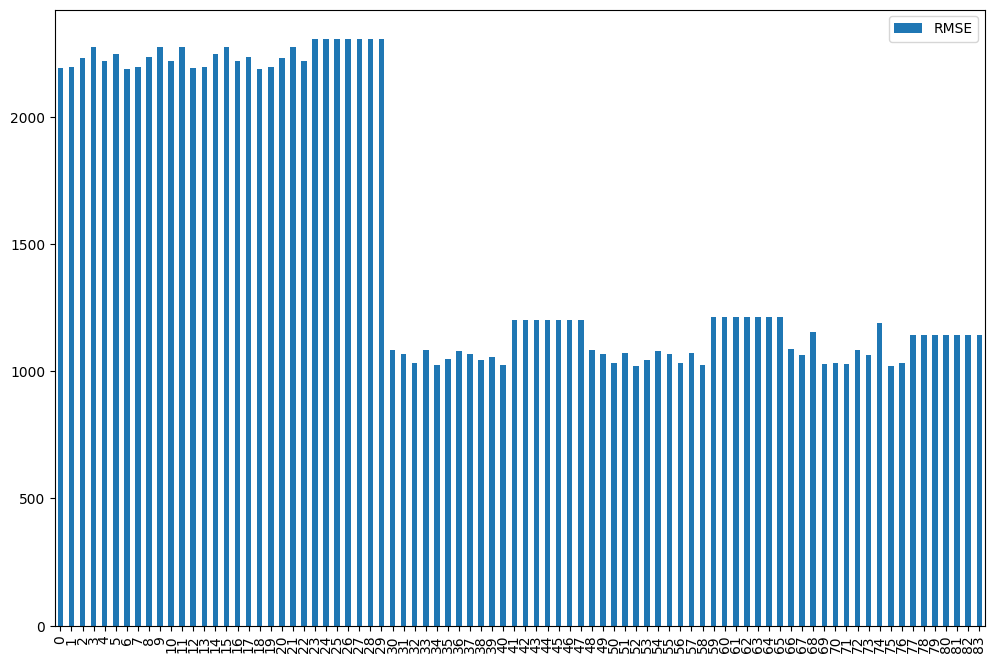

In [234]:
pred_df.plot(kind='bar', figsize=(12,8))

In [236]:
df_new_encoded["prep_time"] = df_new_encoded["eta_sec"] - df_new_encoded["pred_eta"] - df_new_encoded["pred_eot"]

# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-33:].index.tolist(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            X = df_new_encoded[feature_set].drop(columns=["pred_eta", "pred_eot"])
            y = df_new_encoded["prep_time"]

            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index

            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)


-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 1085.4224983848455 in Ridge
Error = 1045.366190981839 in DecisionTree
Error = 1174.5184376283732 in RandomForest
Error = 1016.5966813343431 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 141214, number of used features: 31
[LightGBM] [Info] Start training from score 0.000427


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Error = 1025.542363876834 in LGBM
Error = 1046.4641656549927 in MLP


In [237]:
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-33:].index.tolist(),
}

# continue with best performing model
regression_models = {"XGBoost": XGBRegressor(),}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            X = df_new_encoded[feature_set].drop(columns=["pred_eta", "pred_eot"])
            y = df_new_encoded["prep_time"]

            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index

            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)


-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 1016.5966813343431 in XGBoost


In [238]:
pred_values_dict = {
    "eta_sec": df_new_encoded["eta_sec"][test_indices].values.tolist(),
    "prep_time_pred":y_predict[:,0].tolist(),
    "pred_eta": df_new_encoded["pred_eta"][test_indices].values.tolist(),
    "pred_eot": df_new_encoded["pred_eot"][test_indices].values.tolist(),
    "start_hour": df_new_encoded["start_hour"][test_indices].values.tolist(),
    "start_week_day": df_new_encoded["start_week_day"][test_indices].values.tolist()
}
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,eta_sec,prep_time_pred,pred_eta,pred_eot,start_hour,start_week_day
0,1633.0,1926.241089,488.0,251.0,1.0,1.0
1,2743.0,2286.030029,269.0,251.0,19.0,1.0
2,1576.0,1599.414185,650.0,251.0,1.0,0.0
3,1192.0,1959.714355,305.0,251.0,21.0,4.0
4,4800.0,2872.106934,474.0,251.0,19.0,3.0
...,...,...,...,...,...,...
35299,2970.0,1985.530518,355.0,446.0,4.0,4.0
35300,3049.0,2355.632568,743.0,251.0,2.0,4.0
35301,3629.0,2974.213623,498.0,446.0,1.0,0.0
35302,1904.0,2212.064209,238.0,251.0,0.0,3.0


In [239]:
X = values_df[["prep_time_pred", "pred_eta", "pred_eot", "start_hour", "start_week_day"]]
y = values_df["eta_sec"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [240]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, np.sqrt(mean_squared_error(y_test,y_predict)))

RMSE of: LinearReg 1052.0671820448417
RMSE of: Ridge 1052.0671821816313
RMSE of: DecisionTree 1062.847448689153
RMSE of: RandomForest 1092.0381869917474
RMSE of: XGBoost 1077.2726508134938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 28243, number of used features: 5
[LightGBM] [Info] Start training from score 2848.429487
RMSE of: LGBM 1054.7601398185936
RMSE of: MLP 1048.8480862388649


In [241]:
X = values_df[["prep_time_pred", "pred_eta", "pred_eot"]]
y = values_df["eta_sec"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [242]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, np.sqrt(mean_squared_error(y_test,y_predict)))

RMSE of: LinearReg 1052.3727391645687
RMSE of: Ridge 1052.372739152074
RMSE of: DecisionTree 1064.179136673367
RMSE of: RandomForest 1124.5812066143253
RMSE of: XGBoost 1076.4600013354475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 28243, number of used features: 3
[LightGBM] [Info] Start training from score 2848.429487
RMSE of: LGBM 1055.1886115061022
RMSE of: MLP 1048.9630984234639
